## **Libraries**

In [97]:
!pip install datasets transformers sentence-transformers --quiet

In [98]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report

## EDA & Preprocessing

In [99]:
# Load dataset
data = pd.read_csv('/content/sample_data/dataset_labeled.csv', delimiter=';')

#### Duplicate Tweet

In [100]:
# Cek jumlah data awal
total_awal = len(data)
print(f"Total tweet awal: {total_awal}")

Total tweet awal: 5000


In [101]:
# Cek dan hapus duplikat berdasarkan kolom 'text'
duplikat = data.duplicated(subset='text')
jumlah_duplikat = duplikat.sum()
print(f"Duplikasi tweet ada: {jumlah_duplikat}")

Duplikasi tweet ada: 417


In [102]:
# Hapus duplikat
data = data.drop_duplicates(subset='text').copy()
data.dropna(inplace=True)

In [103]:
# Cek jumlah data setelah dibersihkan
total_setelah = len(data)
print(f"Setelah dihapus tweet duplikat ada: {total_setelah}")
data.head()

Setelah dihapus tweet duplikat ada: 4583


,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


#### Missing Values

In [104]:
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 text     0
label    0
dtype: int64


#### Distribusi Setiap Label

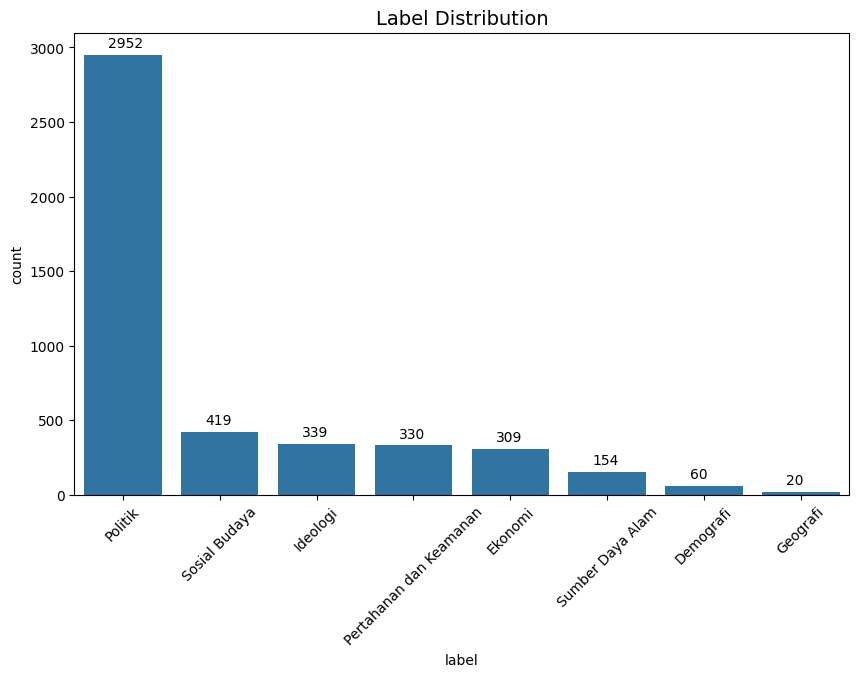

In [105]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='label', data=data, order=data['label'].value_counts().index)
plt.title('Label Distribution', fontsize=14)
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + 0.25, p.get_height() + 50))

plt.show()

#### Preprocessing

In [106]:
# Preprocess function
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # URL
    text = re.sub(r'[^\w\s]', '', text)  # Special chars
    text = re.sub(r'\s+', ' ', text).strip()  # Whitespace
    text = text.lower()  # Lowercase chars
    text = re.sub(r'\b[a-zA-Z0-9]{15,}\b', '', text)  # Random tweet
    return text

data['text'] = data['text'].apply(preprocess_text)

#### Kata-kata yang Paling Muncul

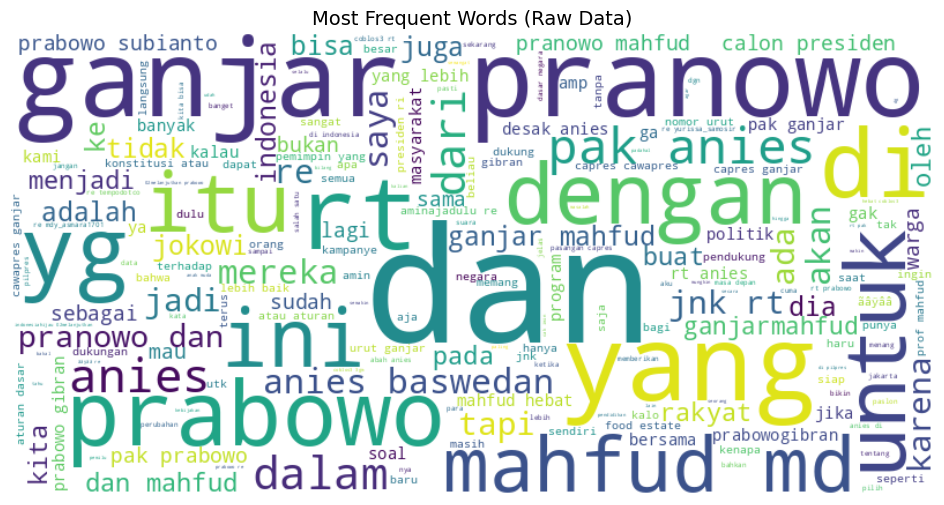

In [107]:
all_words = ' '.join(data['text'])
wordcloud = WordCloud(width=800, height=400,
                      background_color='white').generate(all_words)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words (Raw Data)', fontsize=14)
plt.show()

In [108]:
def get_top_ngrams(texts, n=2, top_n=10):
    n_grams = []
    for text in texts:
        tokens = text.split()
        n_grams.extend(ngrams(tokens, n))
    return Counter(n_grams).most_common(top_n)

# Example for bigrams
bigrams = get_top_ngrams(data['text'], n=2)
print("Top 10 Bigrams:")
for bigram, count in bigrams:
    print(f"{' '.join(bigram)}: {count}")

Top 10 Bigrams:
ganjar pranowo: 1017
mahfud md: 483
pak anies: 476
anies baswedan: 358
pranowo dan: 260
ganjar mahfud: 254
dan mahfud: 210
pranowo mahfud: 176
prabowo subianto: 175
calon presiden: 170


## Model Training (Cosine Similarity)

In [109]:
# Ambil dari kolom 'label' semua label
target_names = sorted(data['label'].unique().tolist())
candidate_labels = [label for label in target_names]
print("candidate_labels = [")
for label in candidate_labels:
    print(f"    '{label}',")
print("]")

# Assign index to each label
label_mapping = {i: label for i, label in enumerate(target_names)}
print("Label Mapping:", label_mapping)

candidate_labels = [
    'Demografi',
    'Ekonomi',
    'Geografi',
    'Ideologi',
    'Pertahanan dan Keamanan',
    'Politik',
    'Sosial Budaya',
    'Sumber Daya Alam',
]
Label Mapping: {0: 'Demografi', 1: 'Ekonomi', 2: 'Geografi', 3: 'Ideologi', 4: 'Pertahanan dan Keamanan', 5: 'Politik', 6: 'Sosial Budaya', 7: 'Sumber Daya Alam'}


## Pemilihan Model

In [110]:
# Load Transformer (diambil dari https://huggingface.co/Rendika/tweets-election-classification)
model = SentenceTransformer("Rendika/tweets-election-classification")

In [111]:
# Generate Train Embeddings
label_embeddings = model.encode(target_names)
train_embeddings = model.encode(data["text"].tolist(), show_progress_bar=True)

sim_matrix = cosine_similarity(train_embeddings, label_embeddings)
predictions = np.argmax(sim_matrix, axis=1)  # Predicted indices

# Align true labels (ground truth) dengan prediksi
y_true_indices = [target_names.index(label) for label in data['label']]

Batches:   0%|          | 0/144 [00:00<?, ?it/s]

## Evaluasi Model

In [112]:
# Classification report
report = classification_report(
    y_true_indices,
    predictions,
    target_names=target_names
)

print(report)

                         precision    recall  f1-score   support

              Demografi       0.50      0.02      0.03        60
                Ekonomi       0.83      0.81      0.82       309
               Geografi       0.11      0.05      0.07        20
               Ideologi       0.76      0.76      0.76       339
Pertahanan dan Keamanan       0.76      0.86      0.81       330
                Politik       0.94      0.87      0.90      2952
          Sosial Budaya       0.54      0.92      0.68       419
       Sumber Daya Alam       0.76      0.64      0.70       154

               accuracy                           0.84      4583
              macro avg       0.65      0.62      0.60      4583
           weighted avg       0.86      0.84      0.84      4583



## Classification Unlabeled Data

In [113]:
# Load dataset
unlabeled_data = pd.read_csv('/content/sample_data/dataset_unlabeled.csv', delimiter=';')

In [114]:
# Cek jumlah data awal
total_awal_un = len(unlabeled_data)
print(f"Total tweet awal: {total_awal_un}")
duplikat_un = unlabeled_data.duplicated(subset='Text')
jumlah_duplikat_un = duplikat_un.sum()
print(f"Duplikasi tweet ada: {jumlah_duplikat_un}")

Total tweet awal: 1000
Duplikasi tweet ada: 0


In [115]:
# Preprocess data (unlabeled)
unlabeled_data['Text'] = unlabeled_data['Text'].apply(preprocess_text)

In [116]:
# Generate embeddings for unlabeled data
label_embeddings = model.encode(target_names)
unlabeled_embeddings = model.encode(unlabeled_data["Text"].tolist(), show_progress_bar=True)

# Zero-Shot Classification
sim_matrix = cosine_similarity(unlabeled_embeddings, label_embeddings)
predictions = np.argmax(sim_matrix, axis=1)

# Add predictions to the DataFrame
predicted_labels = [target_names[i] for i in predictions]
unlabeled_data['predicted_label'] = predicted_labels

# Save the results
print(unlabeled_data[['Text', 'predicted_label']])
unlabeled_data.to_csv('dataset_unlabeled_predicted.csv', index=False)
unlabeled_data.head()


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

                                                  Text  \
0    lu mau org2 prodemokrasi di negara ini bisa pu...   
1    prabowo ditanya soal hutang luar negeri dia me...   
2    kiki_daliyo ganjar pranowo itulah beliau sosok...   
3    kumparan prabowo gibran yang bisa melakukan it...   
4    sniperruben45 uda_zulhendra ainunnajib lah jus...   
..                                                 ...   
995  bikin bangga deh ganjarmahfud mau alokasikan s...   
996  pak jokowi sebelum pilpres 2024 berbesar hati ...   
997   sbaiknya si gemot nga usah ikutan debat dehng...   
998  kebiasaan merembuk atau bermusyawarah jadi gay...   
999  mirage ditolak juwono dibeli prabowo jubir tim...   

             predicted_label  
0                    Politik  
1    Pertahanan dan Keamanan  
2                   Ideologi  
3                    Politik  
4                    Politik  
..                       ...  
995                  Ekonomi  
996                 Ideologi  
997                  Pol

,IDText,Text,predicted_label
0,TXT0001,lu mau org2 prodemokrasi di negara ini bisa pu...,Politik
1,TXT0002,prabowo ditanya soal hutang luar negeri dia me...,Pertahanan dan Keamanan
2,TXT0003,kiki_daliyo ganjar pranowo itulah beliau sosok...,Ideologi
3,TXT0004,kumparan prabowo gibran yang bisa melakukan it...,Politik
4,TXT0005,sniperruben45 uda_zulhendra ainunnajib lah jus...,Politik
